Import package + model

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cobra
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis
from scipy.integrate import solve_ivp
from tqdm import tqdm

In [2]:
M_xanthus = read_sbml_model("../M_xanthus_model.sbml")
M_xanthus

Name,myxo_model
Memory address,7a836590fe00
Number of metabolites,1280
Number of reactions,1367
Number of genes,1192
Number of groups,0
Objective expression,1.0*OF_BIOMASS - 1.0*OF_BIOMASS_reverse_80d2e
Compartments,"c, e"


In [3]:
E_coli = load_json_model("../E_coli_model.json")
E_coli

Name,iML1515
Memory address,7e63fe133a10
Number of metabolites,1877
Number of reactions,2714
Number of genes,1516
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


Rules - Setup dynamic environment

In [ ]:
##COBRApy
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species (Can put more)
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import

def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with E_coli:
        add_dynamic_bounds(E_coli, y)

        cobra.util.add_lp_feasibility(E_coli)
        feasibility = cobra.util.fix_objective_as_constraint(E_coli)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            E_coli, ['BIOMASS_Ec_iML1515_core_75p37M', 'EX_glc__D_e',], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None

def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with E_coli:

        add_dynamic_bounds(E_coli, y)

        cobra.util.add_lp_feasibility(E_coli)
        feasibility = cobra.util.fix_objective_as_constraint(E_coli)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

Run Simulation

In [89]:
ts = np.linspace(0, 10, 20)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system_E_coli,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

0it [00:00, ?it/s]

t = 0.000: : 5it [00:06,  1.25s/it]


KeyboardInterrupt: 

In [101]:
sol

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  5.263e-01  1.053e+00  1.579e+00  2.105e+00
             2.632e+00  3.158e+00  3.684e+00  4.211e+00  4.737e+00
             5.263e+00]
        y: [[ 1.000e-01  1.620e-01 ...  1.479e+00  1.483e+00]
            [ 1.000e+01  9.552e+00 ...  3.738e-02  7.906e-03]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 805
     njev: 29
      nlu: 238

In [ ]:
E_coli.reactions.EX_ac_e #not used in model
E_coli.reactions.EX_etoh_e #not used in model
E_coli.reactions.EX_o2_e

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x7e6348ed25d0
Stoichiometry,o2_e <=> O2 O2 <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


**My Solution**

In [18]:
t = 0
tf = 50
steps = 1
time_point = [0]
it = 1
y = 10
fluxes_E = []

reactions_list_E_coli = []
for reaction in E_coli.reactions:
    reactions_list_E_coli.append(reaction.id)

def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    glucose = y  # expand the boundary species (Can put more)
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import

def update_glucose(fluxes, y):
    y = y + fluxes['EX_glc__D_e']
    return y

with tqdm(total = tf) as pbar:
    while t < tf and y > 0:
        add_dynamic_bounds(E_coli, y)
        FBA_1 = E_coli.optimize()
        fluxes_E_coli = FBA_1.fluxes.get(reactions_list_E_coli)
        fluxes_E_coli *= 0.1 #multiply by Biomass Concentration to get flux?
        time_point.append(time_point[it-1] + steps)
        fluxes_E.append(fluxes_E_coli)
        y = update_glucose(fluxes_E_coli, y)
        it += 1
        t += steps
        pbar.update(steps)
    


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 10.55it/s]


Text(0.5, 1.0, 'Fluxes')

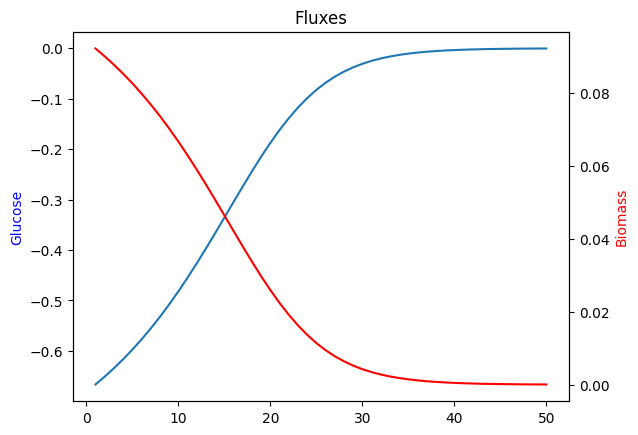

In [19]:
fluxes_E[0]['EX_glc__D_e']
glucose = []
biomass = []

for i in fluxes_E:
 glucose.append(i['EX_glc__D_e'])
 biomass.append(i['BIOMASS_Ec_iML1515_core_75p37M'])

ax = plt.subplot(111)
ax.plot(time_point[1:], glucose)
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], biomass, color='r')

ax.set_ylabel('Glucose', color='b')
ax2.set_ylabel('Biomass', color='r')

ax.set_title('Fluxes')